https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
# # preprocessing cell to make sure everything is named correctly. only need to run it the first time 

# #go through every file and make sure the images have the same name format as their annotation counterpart.
# for classname in os.listdir('./ExDark'):
#     labelpath = os.path.join('./ExDarkAnnotation',classname)
#     imagepath = os.path.join('./ExDark',classname)
#     print('checking imagepath: {} ~ labelpath: {}'.format(imagepath,labelpath))
#     for img_name in os.listdir(imagepath):
#         if img_name[0] != '2':
#             print('{} at {}'.format(img_name,imagepath))
#         lblpath = os.path.join(labelpath,img_name+'.txt')
#         if not os.path.exists(lblpath):
#             print('img path: {}'.format(img_name))
            
# ### found mismatch at './ExDarkAnnotation/Bicycle/2015_00391.JPG.txt'. Also found ipynb_checkpoints.
# ### manually removed ipynb_checkpoints and renamed 2015_00391.JPG to 2015_00391.jpg
# os.rmdir('./ExDark/Bicycle/.ipynb_checkpoints')
# os.rename('./ExDark/Bicycle/2015_00391.JPG','./ExDark/Bicycle/2015_00391.jpg')



In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import time

In [3]:
# Set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  99


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Preprocessing

Before starting, make sure to:
1. Rename img_root/Bicycle/2015_00391.JPG to ExDark/Bicycle/2015_00391.jpg (since ExDarkAnnotation is called 2015_00391.jpg.txt)
2. Remove img_root/Bicycle/.ipynb_checkpoints
3. Remove img_root/Motorbike/2015_05894.jpg (since ExDarkAnnotation/Motorbike/2015_05894.jpg.txt has no box coordinates)

In [5]:
#go through every file and make sure the images have the same name format as their annotation counterpart.
img_root = './ExDark'
            
#check 1
img1 = '{}/Bicycle/2015_00391.JPG'.format(img_root)
if os.path.exists(img1):
    os.rename(img1,'{}/Bicycle/2015_00391.jpg'.format(img_root))

#check 2
if os.path.exists('./ExDark/Bicycle/.ipynb_checkpoints'):
    os.rmdir('./ExDark/Bicycle/.ipynb_checkpoints')

#check 3
img3 = '{}/Motorbike/2015_05894.jpg.txt'.format(img_root)
if os.path.exists(img3):
    os.remove('{}/Motorbike/2015_05894.jpg.txt'.format(img_root))
if os.path.exists('./ExDarkAnnotation/Motorbike/2015_05894.jpg.txt'):
    os.remove('./ExDarkAnnotation/Motorbike/2015_05894.jpg.txt')

#check for any bad files we may have missed
for classname in os.listdir(img_root):
    if classname == '__MACOSX':
        print(' --- please remove __MACOSX folder!!! ---')
        continue
    labelpath = os.path.join('./ExDarkAnnotation',classname)
    imagepath = os.path.join(img_root,classname)
    print('checking imagepath: {} ~ labelpath: {}'.format(imagepath,labelpath))
    for img_name in os.listdir(imagepath):
        if img_name[0] != '2':
            print('{} at {}'.format(img_name,imagepath))
        lblpath = os.path.join(labelpath,img_name+'.txt')
        if not os.path.exists(lblpath):
            print('img path: {}'.format(img_name))

checking imagepath: ./ExDark/Bottle ~ labelpath: ./ExDarkAnnotation/Bottle
checking imagepath: ./ExDark/People ~ labelpath: ./ExDarkAnnotation/People
checking imagepath: ./ExDark/Cup ~ labelpath: ./ExDarkAnnotation/Cup
checking imagepath: ./ExDark/Car ~ labelpath: ./ExDarkAnnotation/Car
checking imagepath: ./ExDark/Dog ~ labelpath: ./ExDarkAnnotation/Dog
checking imagepath: ./ExDark/Chair ~ labelpath: ./ExDarkAnnotation/Chair
checking imagepath: ./ExDark/Boat ~ labelpath: ./ExDarkAnnotation/Boat
checking imagepath: ./ExDark/Bus ~ labelpath: ./ExDarkAnnotation/Bus
checking imagepath: ./ExDark/Motorbike ~ labelpath: ./ExDarkAnnotation/Motorbike
checking imagepath: ./ExDark/Table ~ labelpath: ./ExDarkAnnotation/Table
checking imagepath: ./ExDark/Cat ~ labelpath: ./ExDarkAnnotation/Cat
checking imagepath: ./ExDark/Bicycle ~ labelpath: ./ExDarkAnnotation/Bicycle


# Custom Dataset and Model

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir='./ExDark', label_dir='./ExDarkAnnotation', transform=None):
        '''
        Args:
            img_dir: image root directory containing the different class folders ie 'img_dir/class1/image1'
            label_dir: label root directory containing the different class folders ie 'label_dir/class1/label1'
            transform: transforms to apply to the input image
        '''
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.imagelist = [] #list of lists containing [image_name, class_name]
        # example of self.imagelist[12] = ['2015_01863.png', 'Bottle']
        self.class_to_num = {} #maps class name to numeric value ie {'Bottle':1,'Bicycle':2}
        
        #go through each class folder
        class_counter = 1
        for class_name in os.listdir(img_dir):
            self.class_to_num[class_name] = class_counter
            class_counter += 1
            classpath = img_dir+'/'+class_name # './img_dir/class_name'
            
            #go through each image in the class folder
            for img in os.listdir(classpath): 
                self.imagelist.append([img, class_name])

    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, idx):
        '''
        Returns:
            image: (PIL or a torch.Tensor) input image
            target: (dict) label dictionary required for faster R-CNN
        '''
        image_name, class_folder = self.imagelist[idx]
        img_path = os.path.join(self.img_dir,class_folder,image_name)
        target_path = os.path.join(self.label_dir,class_folder,image_name+'.txt')
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            image = self.transform(image)
            image = image.to(dtype=torch.float32)
        
        boxes = []
        labels = []
        with open(target_path,'r') as f:
            for line in f:
                if line[0] == '%':
                    continue
                else:
                    line = line.split()
                    classlabel = line[0]
                    labels.append(self.class_to_num[classlabel])
                    xmin = int(line[1])
                    ymin = int(line[2])
                    xmax = xmin + int(line[3])
                    ymax = ymin + int(line[4])
                    boxes.append([xmin, ymin, xmax, ymax]) #bounding box coords
        
        assert len(boxes) == len(labels)
        
        #turn everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 13  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
# input_transform = T.Compose([T.PILToTensor()])
input_transform = T.Compose([T.ToTensor()])
dataset = CustomImageDataset(img_dir='./ExDarkLIME',label_dir='./ExDarkAnnotation',transform=input_transform)
dataset_test = CustomImageDataset(img_dir='./ExDarkLIME',label_dir='./ExDarkAnnotation',transform=input_transform)

#split the dataset into train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-1412])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-1412:])

# Train

GPU out of memory error/ kernel dying with large batch_size.

In [9]:
batch_size = 4
iterations = int(len(dataset)/batch_size) #chose 1412 so we can divide dataset by batch_size=32 evenly
num_epochs = 1

model = model.to(device)
# model.train() #not needed?

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


losslist = [] #for graphing losses afterwards
#TODO - 
### add validation loss stuff? or just train loss
for epoch in range(num_epochs):
    print('starting epoch {}'.format(epoch))
    for it in range(iterations):
        if it%200 == 0:
            print('batch {}/{}'.format(it,iterations))
        #get batch data
        #faster r-cnn expects 2 inputs: a list of images and a list of target dictionaries
        images = []
        targets = []
        for b in range(batch_size*it,batch_size*(it+1)):
            img, t = dataset[b]
            images.append(img.to(device))
#             images.append(img)
            t['boxes'] = t['boxes'].to(device) #have to convert the target dictionary to gpu
            t['labels'] = t['labels'].to(device)
            targets.append(t)
            
        #forward pass through model and backprop
        '''
        follows the same logic as train_one_epoch() found here:
        https://github.com/pytorch/vision/blob/main/references/detection/engine.py
        '''
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        if it%100 == 0:
            losslist.append(losses.item())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        

starting epoch 0
batch 0/1481


/home/cys005/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


batch 200/1481
batch 400/1481
batch 600/1481
batch 800/1481
batch 1000/1481
batch 1200/1481
batch 1400/1481


In [10]:
losslist

[3.2497503757476807,
 1.0937858819961548,
 0.835546612739563,
 0.6529459357261658,
 0.6973803639411926,
 0.8236184120178223,
 0.5377524495124817,
 0.9360153079032898,
 0.602578341960907,
 0.5009042620658875,
 1.0484868288040161,
 0.47304338216781616,
 0.4323436915874481,
 0.7442799210548401,
 0.9786298871040344]

# Evaluating the model (before training)

In [7]:
input_img, input_labels = dataset[0]

In [8]:
model.eval()
predictions = model([input_img],[input_labels])

/home/cys005/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
predictions

[{'boxes': tensor([[214.9634, 265.0150, 217.6837, 266.9099],
          [193.6286,  29.8344, 202.2809,  30.5045],
          [230.3998, 125.0793, 230.4353, 375.0000],
          [206.4981, 184.7162, 206.8563, 373.3907],
          [247.5353, 266.0909, 251.0146, 266.9047],
          [  0.0000, 164.8547, 500.0000, 375.0000],
          [176.0184,  45.4838, 184.6853,  45.7772],
          [215.6661, 193.0665, 216.6025, 353.0614],
          [107.7315, 265.1644, 161.4726, 266.9745],
          [177.4051,  17.6351, 196.3401,  19.4731],
          [245.3780, 232.1779, 254.2553, 270.3298],
          [  0.0000,  38.9870, 500.0000, 285.9873],
          [240.6835,  56.4041, 240.7529, 375.0000],
          [  0.0000, 253.6326, 500.0000, 272.1951],
          [  0.0000,   0.0000,  54.5967, 375.0000],
          [408.3451, 202.3556, 434.1322, 243.9326],
          [  0.0000, 196.3070, 500.0000, 205.2413],
          [199.8593, 254.4083, 207.0360, 255.3645],
          [  0.0000, 157.2345, 500.0000, 183.3657],
   

In [24]:
npimg = input_img.detach().numpy()
npimg2 = npimg.astype(int)

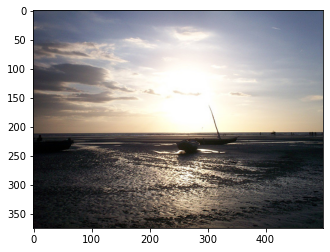

In [25]:
plt.imshow(np.transpose(npimg2,(1,2,0)))

In [36]:
img = np.transpose(npimg2,(1,2,0))

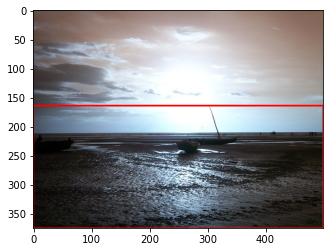

In [39]:
import cv2
# img = Image.open('./ExDark/Bottle/2015_01362.jpg').convert("RGB")
# img = cv2.imread('./ExDark/Bottle/2015_01362.jpg')
color=(255,0,0)
thickness=2
# for i in range(len(target[0]['boxes'])):
#     xmin,ymin,xmax,ymax = target[0]['boxes'][i]
#     start_point = (int(xmin),int(ymin))
#     end_point = (int(xmax),int(ymax))

#the split() and merge() is to make a numpy array usable for cv2.rectangle()
r,g,b = cv2.split(img)
img_bgr = cv2.merge([r,g,b])
img = cv2.rectangle(img_bgr, (0,164), (500,375), color, thickness) #picked the 6th element from predictions boxes
plt.imshow(img)

In [38]:
img.shape

(375, 500, 3)

In [34]:
cv2.split(img)

(array([[74, 76, 74, ..., 79, 80, 82],
        [73, 73, 72, ..., 80, 80, 79],
        [69, 69, 72, ..., 80, 79, 79],
        ...,
        [ 2,  8,  8, ..., 13, 13, 17],
        [ 2,  9,  6, ...,  7,  7,  9],
        [ 6, 14, 12, ...,  9,  8,  9]], dtype=int32),
 array([[ 71,  75,  75, ...,  99, 100, 100],
        [ 74,  76,  77, ..., 100, 100,  99],
        [ 76,  78,  81, ..., 100, 101,  99],
        ...,
        [  8,  12,   9, ...,  23,  21,  20],
        [  2,   9,   5, ...,  13,  11,  13],
        [  4,   9,  10, ...,  13,  12,  13]], dtype=int32),
 array([[ 90,  93,  95, ..., 123, 124, 122],
        [ 94,  95,  96, ..., 125, 124, 123],
        [ 94,  95,  98, ..., 127, 125, 124],
        ...,
        [  8,  13,  13, ...,  24,  23,  25],
        [  4,  11,  10, ...,  13,  12,  14],
        [  5,  13,  15, ...,  14,  13,  12]], dtype=int32))

# Evaluating model (after training)

(trained only on 1 epoch, need to train more)

In [11]:
input_img, input_labels = dataset[0]

model.eval()

input_labels['boxes'] = input_labels['boxes'].to(device)
input_labels['labels'] = input_labels['labels'].to(device)
predictions = model([input_img.to(device)],[input_labels])

In [12]:
predictions

[{'boxes': tensor([[208.1698, 194.8180, 309.2679, 288.4512],
          [407.7758, 196.8405, 474.2444, 266.9595],
          [216.9123, 223.6129, 298.7819, 276.3587],
          [247.8535, 195.2783, 313.1878, 257.7235],
          [403.4205, 188.5611, 437.4143, 228.5503],
          [136.2767, 174.7069, 312.0361, 293.9641],
          [258.6835, 196.9593, 307.5893, 228.3994],
          [ 86.3530, 230.6994, 109.3476, 277.6791],
          [267.9984, 164.6245, 409.4807, 259.0609],
          [250.0206, 205.7254, 309.9094, 236.2411],
          [248.6242, 171.0978, 272.2563, 216.0868],
          [121.0984, 171.6715, 307.8701, 340.3344],
          [402.3433, 191.0682, 459.4565, 245.7849],
          [120.6986, 209.9503, 233.2227, 336.6669],
          [403.8711, 186.1454, 425.2094, 221.3102],
          [115.8829, 193.3508, 200.9140, 333.3643],
          [250.2359, 172.2962, 270.2830, 215.7516],
          [463.3364, 191.4929, 480.3886, 230.3474],
          [441.6839, 196.8299, 454.1355, 223.8697],
   

In [13]:
test_img, test_box = dataset[0]
model.eval()
output = model([test_img.to(device)])
np_img = test_img.numpy()
np_img = np.transpose(np_img,(1,2,0))

predicted = {'boxes':[],'labels':[],'scores':[]}
for label_dict in output:
    s = label_dict['scores']
    for i in range(len(s)):
        if s[i] > 0.8:
            predicted['boxes'].append(label_dict['boxes'][i].tolist())
            predicted['labels'].append(label_dict['labels'][i].tolist())
            predicted['scores'].append(s[i].tolist())
        else:
            #scores should be sorted so we just stop checking after reaching the first elem<0.8
            break
#     for k in label_dict:
#         print("length of k: {}".format(len(label_dict[k])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


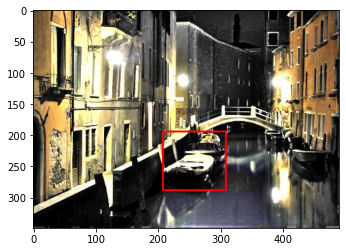

In [14]:
import cv2
color=(255,0,0)
thickness=2
r,g,b = cv2.split(np_img)
img_bgr = cv2.merge([r,g,b])
for i in range(len(predicted['boxes'])):
    xmin,ymin,xmax,ymax = predicted['boxes'][i]
    start_point = (int(xmin),int(ymin))
    end_point = (int(xmax),int(ymax))
    img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)

plt.imshow(img_bgr);

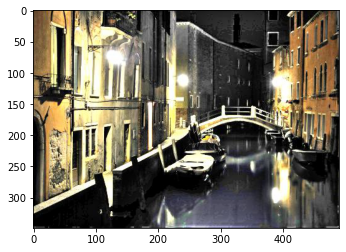

In [16]:
np_img = input_img.numpy()
np_img = np.transpose(np_img,(1,2,0))
plt.imshow(np_img)

# random tests

In [46]:
img,d = dataset[0]

In [47]:
img

tensor([[[ 76.,  80.,  85.,  ...,  53., 254.,   0.],
         [ 84.,  87.,  92.,  ...,  55., 255.,   0.],
         [ 90.,  93.,  97.,  ...,  57., 255.,   2.],
         ...,
         [ 10.,   5.,   6.,  ...,  13., 255.,  29.],
         [255., 124., 135.,  ..., 255., 238., 114.],
         [  0.,  17.,   4.,  ...,  25.,  43.,   7.]],

        [[ 50.,  54.,  59.,  ...,  51., 252.,   0.],
         [ 58.,  61.,  66.,  ...,  53., 255.,   0.],
         [ 64.,  67.,  71.,  ...,  55., 255.,   2.],
         ...,
         [ 10.,   5.,   6.,  ...,  13., 255.,  29.],
         [255., 124., 135.,  ..., 255., 238., 114.],
         [  0.,  17.,   4.,  ...,  25.,  43.,   7.]],

        [[ 23.,  27.,  32.,  ...,  54., 255.,   4.],
         [ 31.,  34.,  39.,  ...,  56., 255.,   4.],
         [ 37.,  40.,  44.,  ...,  58., 255.,   4.],
         ...,
         [ 10.,   5.,   6.,  ...,  13., 255.,  29.],
         [255., 124., 135.,  ..., 255., 238., 114.],
         [  0.,  17.,   4.,  ...,  25.,  43.,   7.]]]

In [48]:
d

{'boxes': tensor([[199., 227., 297., 286.],
         [362., 187., 417., 224.]]),
 'labels': tensor([9, 9])}

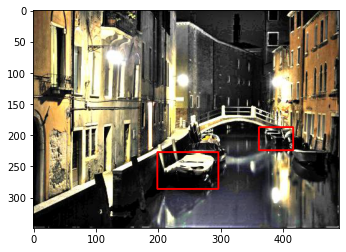

In [49]:
import cv2
np_img = img.to(torch.uint8).numpy()
np_img = np.transpose(np_img,(1,2,0))
color=(255,0,0)
thickness=2
r,g,b = cv2.split(np_img)
img_bgr = cv2.merge([r,g,b])
for i in range(len(d['boxes'])):
    xmin,ymin,xmax,ymax = d['boxes'][i]
    start_point = (int(xmin),int(ymin))
    end_point = (int(xmax),int(ymax))
    img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)

plt.imshow(img_bgr);
# or plt.imshow(img_bgr.astype(np.uint8)) if you don't want to use .to(torch.uint8) above.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


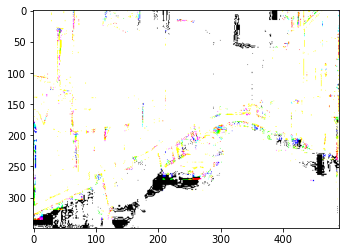

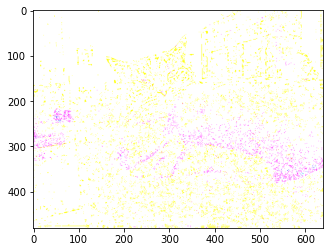

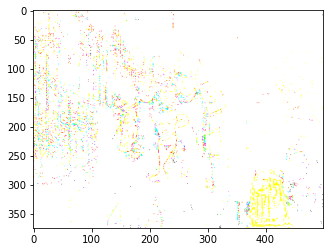

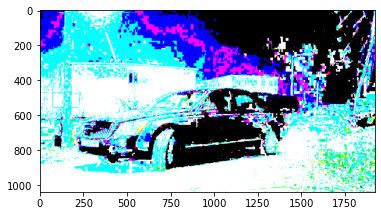

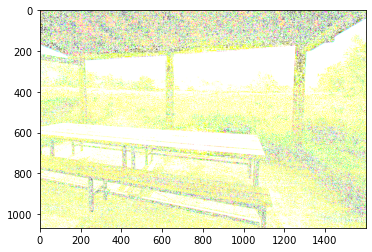

In [39]:
for i in range(5):
    img, d = dataset[i]
    np_img = img.numpy()
    np_img = np.transpose(np_img,(1,2,0))
    plt.figure()
    plt.imshow(np_img)

NOTE: There is a difference when plotting img with dtype float vs img with dtype int

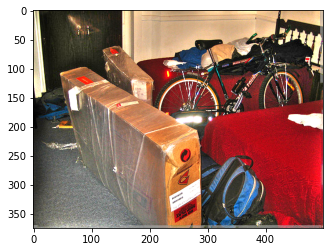

In [31]:
img = Image.open('./ExDarkLIME/Bicycle/2015_00001.png')
np_img = np.array(img)
plt.imshow(np_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


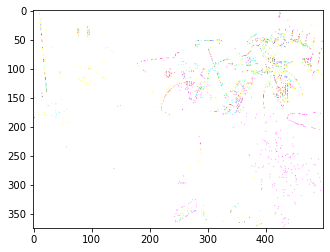

In [30]:
img = Image.open('./ExDarkLIME/Bicycle/2015_00001.png')
np_img = np.array(img,dtype=np.float32)
plt.imshow(np_img)